In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc


In [2]:
import utils
from config import store_dir, data_dir, date_key
%load_ext autoreload
%autoreload 2

# Load data

In [3]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )

In [4]:
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )

In [5]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

# Make table with all features and create AnnData object

Make feature list/table 

In [6]:
fdr_cutoff = 0.5

In [35]:
# Get all features

features = []
for tab in tqdm(results.values()):
    tmp_tab = tab[tab['fdr'] <= 0.5]
    for ix in tmp_tab['ion']:
            features.append(ix)
features = list(set(features))

100%|██████████| 7443/7443 [00:05<00:00, 1242.48it/s]


In [36]:
len(features)

77087

In [37]:
# Initialize empty df
fdr_data = pd.DataFrame(0, columns=list(set(features)), index=results.keys(), dtype='float64')

In [38]:
fdr_data.shape

(7443, 77087)

In [39]:
# Fill dataframe
for i in tqdm(results.keys()):
    # It is late, I lost my creativity for variable names
    tmp_tab = results[i][results[i]['fdr'] <= 0.5]
    
    ttt = tmp_tab.reset_index()[['ion', 'intensity']]
    ttt2 = ttt.groupby('ion').sum()
    
    fdr_data.loc[i, ttt2.index] = ttt2['intensity'].values

100%|██████████| 7443/7443 [02:23<00:00, 51.80it/s]


In [51]:
adata = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])

/tmp/ipykernel_3106/3986562972.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(X=fdr_data.to_numpy(), var=pd.DataFrame(features), obs=mdt.loc[fdr_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [52]:
adata

AnnData object with n_obs × n_vars = 7443 × 77087
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax'
    var: 0

In [53]:
sc.pp.filter_genes(adata, min_cells=200)
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.normalize_total(adata, target_sum=1e4)


In [54]:
adata

AnnData object with n_obs × n_vars = 6504 × 9437
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'n_genes'
    var: 0, 'n_cells'

In [55]:
sc.pp.neighbors(adata, metric='cosine')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
sc.tl.umap(adata)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


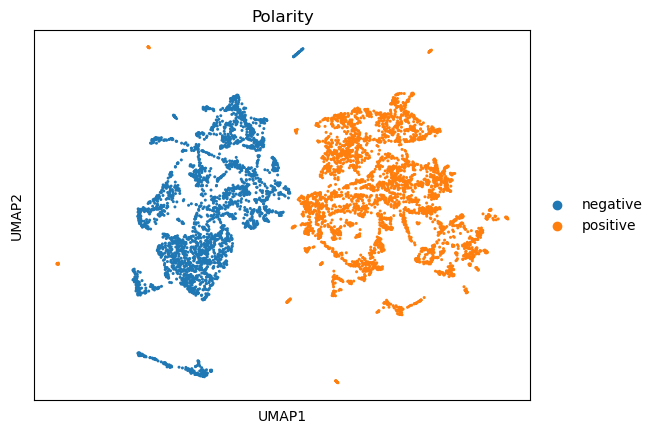

In [58]:
sc.pl.umap(adata, color='Polarity')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


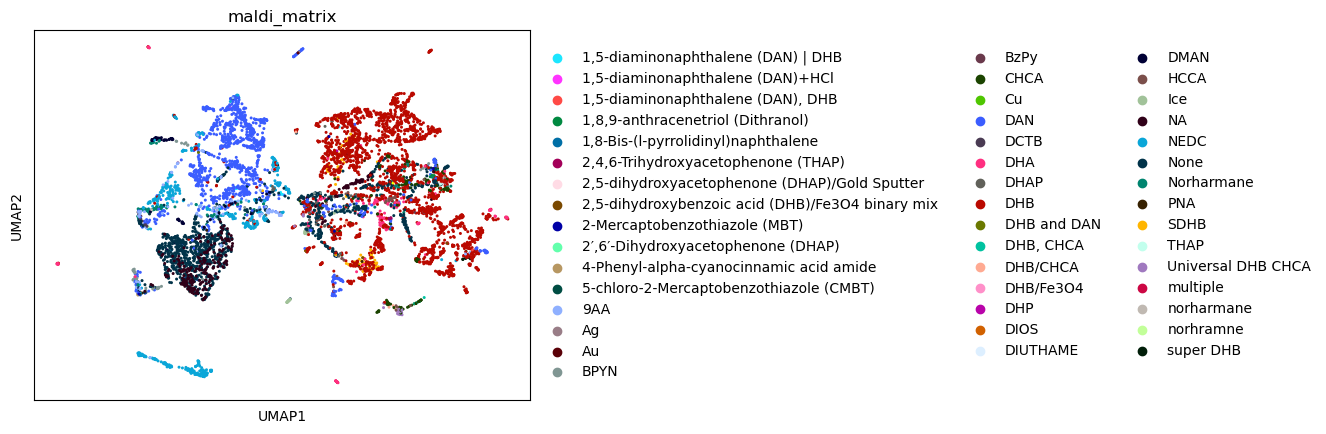

In [60]:
sc.pl.umap(adata, color='maldi_matrix')

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


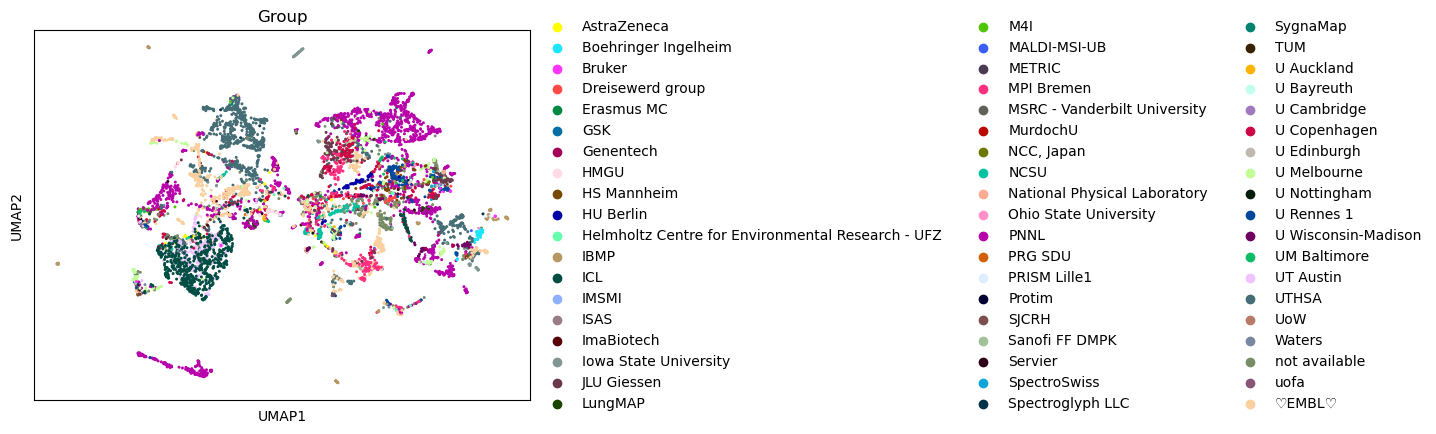

In [61]:
sc.pl.umap(adata, color='Group')

# Continue here:

* coloring only by top 20 features
* Clean up MALDI matrix more
* Play with batch correction